In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 735.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=0ca7c860ac4599952e9767733d380f697ab4d6b96ac797e0b47d040718c4d31e
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
!pip install generic_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 1.3 MB/s eta 0:00:00


In [ ]:
from keras.utils import to_categorical

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib import pyplot
from numpy import interp
import sklearn, tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from xgboost import XGBClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import pandas as pd
import random
from keras.layers import Input, Dense
from keras import Model
from keras.models import Sequential, model_from_config,Model
from keras.layers import  Dropout, Activation, Flatten
import np_utils
import generic_utils
from keras.constraints import MaxNorm

In [ ]:
def prepare_data(seperate=False):
    print ("loading data")   #loading the dataset
    disease_sim = np.loadtxt("/content/drive/MyDrive/minor project/RNA_S.txt",dtype=float,delimiter="\t")  #piRNA similarity data
    piRNA_sim  = np.loadtxt("/content/drive/MyDrive/minor project/DIS_S.txt",dtype=float,delimiter="\t")   #disease similarity data
    interaction = np.loadtxt("/content/drive/MyDrive/minor project/D_R_A.txt",dtype=int,delimiter="\t")    # piRNA - disease association




    link_number = 0
    train = []
    testf= []
    label1 = []
    label2 = []
    label22=[]
    ttf=[]
    for i in range(0, interaction.shape[0]):   # shape[0] returns m if interaction is m*n, ie, returns no. of rows of matrix
        for j in range(0, interaction.shape[1]):  # shape[0] returns no. of columns of matrix

            if interaction[i, j] == 1:                      #for associated
                label1.append(interaction[i,j])             #label1= labels for association(1)
                link_number = link_number + 1               #no. of associated samples
                #link_position.append([i, j])
                piRNA_sim_tmp = list(piRNA_sim[i])       # piRNA similarity vector for associated samples
                disease_sim_tmp = list(disease_sim[j])    # disease similarity vector for associated
                tmp_sim = (piRNA_sim_tmp,disease_sim_tmp)   #concatnated feature vector for an association
                train.append(tmp_sim)                       #train contains feature vectors of all associated samples
            elif interaction[i,j] == 0:                     #for no association
                label2.append(interaction[i,j])             #label2= labels for no association(0)
                piRNA_sim_tmp1 = list(piRNA_sim[i])
                disease_sim_tmp1 = list(disease_sim[j])
                test_sim= (piRNA_sim_tmp1,disease_sim_tmp1) #concatenated feature vector for not having association
                testf.append(test_sim)                    #testfnl contains feature vectors of all non associated samples
    print(len(train))
    print('************')
    print(len(testf))
    #print(link_number)
    print("link_number",link_number)   # no. of associated

    m = np.arange(len(label2))
    np.random.shuffle(m)

    for x in m:
        ttf.append(testf[x])
        label22.append(label2[x])
    #print('************')
    #print(ttfnl)
    #print('************')
    #print(label22)
    for x in range(0, link_number):                         #for equalizing positive and negative samples
        tfnl= ttf[x]                                    #tfnl= feature vector pair for no association
        lab= label22[x]                                      #lab= label of the above mentioned feature vector pair(0)
        #print(tfnl)
        #print('***')
        train.append(tfnl)                                  #append the non associated feature vector pairs to train till x<=no. of associated pairs
        label1.append(lab)                                   #append the labels of non associated pairs(0) to label1

    print(len(train))
    print(len(label1))
    print(len(testf))
    return np.array(train), label1, np.array(testf)




In [ ]:
def transfer_array_format(data):    #data=X  , X= all the piRNA features, disease features
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])   #contains piRNA features
        formated_matrix2.append(val[1])   #contains disease features
    return np.array(formated_matrix1), np.array(formated_matrix2)

In [ ]:
def D_auto(x_train):

    encoding_dim = 128
    input_img = Input(shape=(523,))
    encoded = Dense(400, activation='relu')(input_img)   # 400 - output (input layer)
    encoded = Dense(300, activation='relu')(encoded)    # 300 - output (hidden layer1)
    encoded = Dense(200, activation='relu')(encoded)     # 200 - output (hidden layer2)
    encoded = Dense(100, activation='relu')(encoded)    # 100 - output (hidden layer3)
    encoder_output = Dense(encoding_dim)(encoded)
    #print(encoder_output)
# decoder layers
    decoded = Dense(175, activation='relu')(encoder_output)
    decoded = Dense(200, activation='relu')(decoded)
    decoded = Dense(300, activation='relu')(decoded)
    decoded = Dense(523, activation='tanh')(decoded)

    autoencoder = Model(input_img, decoded)

    encoder = Model(input_img,encoder_output)

    autoencoder.compile(optimizer='adam', loss='mse')


    autoencoder.fit(x_train, x_train,epochs=20,batch_size=100,shuffle=True)
    #batch_size=100 original
    encoded_imgs = encoder.predict(x_train)

    print("???????????????????")
    print(encoded_imgs.shape)  #(2424,128)

    return encoder_output,encoded_imgs

def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = to_categorical(y)
    return y, encoder


In [ ]:
def DeepMDA():
    X, labels,T = prepare_data(seperate = True)     #X= array of concatenated features(train data),labels=corresponding labels, T = test data

    X_data1, X_data2 = transfer_array_format(X) # X-data1 = disease features (22*22) , X_data2 = piRNA features (501*501)

    print("************")
    print (X_data1.shape,X_data2.shape)  # (2424,22), (2424,501)
    print("******************")


    X_data1= np.concatenate((X_data1, X_data2 ), axis = 1) #axis=1 , rowwise concatenation

    print("************")
    print (X_data1.shape)  # (2424,523)
    print("******************")

    y, encoder = preprocess_labels(labels)# labels labels_new
    print(len(y))
    num = np.arange(len(y))   #num gets an array like num = [0,1,2...len(y)], len(y) = 501*22 = 36352
    #print(num)
    np.random.shuffle(num)
    X_data1 = X_data1[num]
    #X_data2 = X_data2[num]
    y = y[num]

    t=0
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    encoder,X_data1 = D_auto(X_data1)

    num_cross_val = 5
    all_performance_LGBM = []
    all_labels = []
    all_prob = {}
    all_prob[0] = []
    all_prob[1] = []
    all_prob[2] = []
    all_prob[3] = []
    all_averrage = []
    for fold in range(num_cross_val):
        train1 = np.array([x for i, x in enumerate(X_data1) if i % num_cross_val != fold])
        test1 = np.array([x for i, x in enumerate(X_data1) if i % num_cross_val == fold])
        print(len(train1))
        print(len(test1))
        train_label = np.array([x for i, x in enumerate(y) if i % num_cross_val != fold])
        test_label = np.array([x for i, x in enumerate(y) if i % num_cross_val == fold])
        #print(test_label)
        #print("$$$$$$$$$$$$",test1)
        #print(test2)

        real_labels = []
        for val in test_label:
            if val[0] == 1:
                real_labels.append(0)
            else:
                real_labels.append(1)
        #print("the size of real ",len(real_labels))
        train_label_new = []
        for val in train_label:
            if val[0] == 1:
                train_label_new.append(0)
            else:
                train_label_new.append(1)
        prefilter_train = train1
        prefilter_test = test1
       # print(real_labels)


        #clf = RandomForestClassifier(n_estimators=200)
        #clf = XGBClassifier(n_estimators = 200, learning_rate = 0.2, max_depth= 15)
        clf = LGBMClassifier(n_estimators=  150,num_leaves= 10, learning_rate = 0.2, max_depth= 15)
        #clf = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2,random_state=0)
        #clf = CatBoostClassifier(n_estimators = 200, learning_rate = 0.2,random_state=0)


        clf.fit(prefilter_train, train_label_new)    #***Training

        ae_y_pred_prob = clf.predict_proba(prefilter_test)[:,1]   #**testing

        #print(ae_y_pred_prob)

        proba = transfer_label_from_prob(ae_y_pred_prob)
        #print(proba)
        #print(encoder.shape)
        #print(X_data1.shape)
        #print(X_data2.shape)
        acc, precision, sensitivity, specificity, MCC, f1_score = calculate_performace(len(real_labels), proba,  real_labels)

        fpr, tpr, auc_thresholds = roc_curve(real_labels, ae_y_pred_prob)
        auc_score = auc(fpr, tpr)
#        print("Length")
#        print(len(real_labels))
        ## AUPR score add
        precision1, recall, pr_threshods = precision_recall_curve(real_labels, ae_y_pred_prob)
        aupr_score = auc(recall, precision1)
        print ("AUTO-LGBM:",acc, precision, sensitivity, specificity, MCC, auc_score, aupr_score,f1_score)
        all_performance_LGBM.append([acc, precision, sensitivity, specificity, MCC, auc_score, aupr_score,f1_score])
        t =t+1  #  AUC fold number

        pyplot.plot(fpr,tpr,label= 'ROC fold %d (AUC = %0.4f)' % (t, auc_score))
        mean_tpr += interp(mean_fpr, fpr, tpr) # one dimensional interpolation
        mean_tpr[0] = 0.0

        pyplot.xlabel('False positive rate, (1-Specificity)')
        pyplot.ylabel('True positive rate,(Sensitivity)')
        pyplot.title('Receiver Operating Characteristic curve: 5-Fold CV')
        pyplot.legend()

    mean_tpr /= num_cross_val
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pyplot.plot(mean_fpr, mean_tpr,'--' ,linewidth=2.5,label='Mean ROC (AUC = %0.4f)' % mean_auc)
    pyplot.legend()
    pyplot.show()




    print('*******AUTO-LGBM*****')
    print ('mean performance of LGBM using raw feature')
    print (np.mean(np.array(all_performance_LGBM), axis=0))
    Mean_Result=[]
    Mean_Result= np.mean(np.array(all_performance_LGBM), axis=0)
    print ('---' * 20)
    print('Mean-Accuracy=', Mean_Result[0],'\n Mean-precision=',Mean_Result[1])
    print('Mean-Sensitivity=', Mean_Result[2], '\n Mean-Specificity=',Mean_Result[3])
    print('Mean-MCC=', Mean_Result[4],'\n' 'Mean-auc_score=',Mean_Result[5])
    print('Mean-Aupr-score=', Mean_Result[6],'\n' 'Mean_F1=',Mean_Result[7])
    print ('---' * 20)

    print(X_data1.shape)


loading data
1212
************
9810
link_number 1212
2424
2424
9810
************
(2424, 22) (2424, 501)
******************
************
(2424, 523)
******************
2424


<ipython-input-9-d882b22fdb12>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train), label1, np.array(testf)


Epoch 1/20
25/25 [==============================] - 2s 17ms/step - loss: 0.0370
Epoch 2/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0196
Epoch 3/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0140
Epoch 4/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 5/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0088
Epoch 6/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0074
Epoch 7/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 8/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0057
Epoch 9/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0052
Epoch 10/20
25/25 [==============================] - 1s 27ms/step - loss: 0.0047
Epoch 11/20
25/25 [==============================] - 1s 26ms/step - loss: 0.0043
Epoch 12/20
25/25 [==============================] - 1s 26ms/step - loss: 0.0041
Epoch 13/20
25/25 [==================

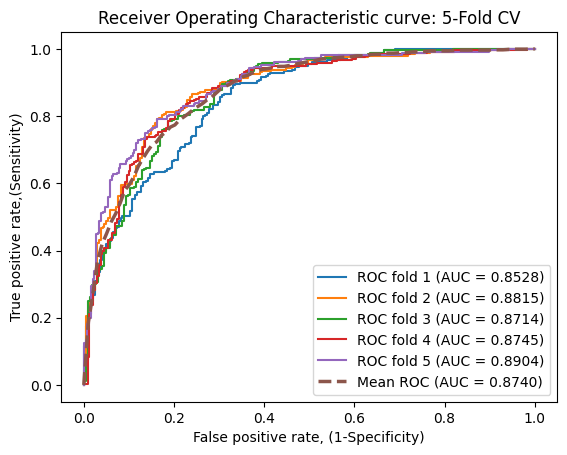

*******AUTO-LGBM*****
mean performance of LGBM using raw feature
[0.79455738 0.79454542 0.79775857 0.792734   0.59088324 0.87411262
 0.85950091 0.794981  ]
------------------------------------------------------------
Mean-Accuracy= 0.7945573826361081 
 Mean-precision= 0.7945454244662044
Mean-Sensitivity= 0.7977585690636693 
 Mean-Specificity= 0.7927340011282459
Mean-MCC= 0.5908832387170884 
Mean-auc_score= 0.8741126181683223
Mean-Aupr-score= 0.8595009059154908 
Mean_F1= 0.7949810027776403
------------------------------------------------------------
(2424, 128)


In [ ]:
def transfer_label_from_prob(proba):
    label = [1 if val>=0.5 else 0 for val in proba]
    return label


if __name__=="__main__":
    DeepMDA()


In [ ]:
def calculate_performace(test_num, pred_y,  labels): #pred_y = proba, labels = real_labels
    tp =0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] ==1:
            if labels[index] == pred_y[index]:
                tp = tp +1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn +1
            else:
                fp = fp + 1

    acc = float(tp + tn)/test_num

    if tp == 0 and fp == 0:
        precision = 0
        MCC = 0
        f1_score=0
        sensitivity =  float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
    else:
        precision = float(tp)/(tp+ fp)
        sensitivity = float(tp)/ (tp+fn)
        specificity = float(tn)/(tn + fp)
        MCC = float(tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
        f1_score= float(2*tp)/((2*tp)+fp+fn)

    return acc, precision, sensitivity, specificity, MCC,f1_score
